In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function

# import glob
import os

import cv2
import numpy as np
import tensorflow as tf

2023-04-09 20:07:36.487300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/.conda/envs/casapose/lib/python3.8/site-packages/cv2/../../lib64:
2023-04-09 20:07:36.487337: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
class opt:
    modelname = 'casapose_c_gcu5'
    estimate_confidence = 1
    estimate_coords = 1
    confidence_regularization = 1
    object = 'obj_000001,obj_000005,obj_000006,obj_000008,obj_000009,obj_000010,obj_000011,obj_000016'

    no_points = 9
    save_debug_batch = 0

    imagesize = (448, 448)
    imagesize_test = (480, 640)
    crop_factor = 0.933333333
    pretrained = 1
    manualseed = 1237

    # losses
    mask_loss_weight = 1.0
    vertex_loss_weight = 0.5
    proxy_loss_weight = 0.015
    keypoint_loss_weight = 0.007
    filter_vertex_with_segmentation = 1
    filter_high_proxy_errors = 0
    use_bpnp_reprojection_loss = 0
    max_keypoint_pixel_error = 12.5

    # learning rate
    lr = 0.001
    lr_decay = 0.5
    lr_epochs_steps = 50,75,90

    # general
    gpuids = 0,1
    loginterval = 10
    epochs = 100
    batchsize = 4
    saveinterval = 5
    validationinterval = 1

    # data preprocessing
    workers = 0
    prefetch = 10

    # augmentation
    translation = 0
    rotation = 0
    noise = 0.0001
    brightness = 0.001
    contrast = 0.001
    saturation = 0.001
    hue = 0.001
    use_imgaug = 1

    # test
    min_object_size_test = 200
    write_poses = 0
    save_eval_batches = 0

    # output
    net = 'training_checkpoints'
    outf = 'train_casapose_8_16_objects'

    # config
    train_vectors_with_ground_truth = 1
    load_h5_weights = 0
    copy_weights_from_backup_network = 0
    copy_weights_add_confidence_maps = 0
    objects_in_input_network = 8
    objects_to_copy = 1
    objects_to_copy_list = 'config/objects_to_copy.csv'
    
    confidence_filter_estimates = 1
    confidence_choose_second = 0
    train_vectors_with_ground_truth = 0
    datatest_wxyz_quaterion = 0
    filter_test_with_gt = 0

In [4]:
os.environ["CASAPOSE_INFERENCE"] = "True"

from casapose.data_handler.vectorfield_dataset import VectorfieldDataset
from casapose.data_handler.image_only_dataset import ImageOnlyDataset
from casapose.pose_estimation.pose_evaluation import (
    estimate_and_evaluate_poses,
    evaluate_pose_estimates,
)
from casapose.pose_estimation.voting_layers_2d import CoordLSVotingWeighted
from casapose.pose_models.tfkeras import Classifiers
from casapose.utils.config_parser import parse_config
#from casapose.utils.dataset_utils import save_eval_batch  # , save_eval_comparison
from casapose.utils.inf_dataset_utils import save_eval_batch  # , save_eval_comparison
from casapose.utils.image_utils import get_all_vectorfields
# from casapose.utils.io_utils import write_poses
from casapose.utils.loss_functions import (
    keypoint_reprojection_loss,
    proxy_voting_dist,
    proxy_voting_loss_v2,
    smooth_l1_loss,
)

/home/ubuntu/.conda/envs/casapose/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)
/home/ubuntu/.conda/envs/casapose/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

2023-04-09 20:07:38.755108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 20:07:38.843737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-09 20:07:38.845642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/.conda/envs/casapose/lib/python3.8/site-packages/cv2/../../lib64:
2023-04-09 20:07:38.845696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

In [6]:
def compute_loss(
    output_seg,
    target_seg,
    output_vertex,
    target_vertex,
    target_points,
    mask_loss_weight=1.0,
    vertex_loss_weight=1.0,
    proxy_loss_weight=1.0,
    kp_loss_weight=0.0,
    kp_loss=None,
):

    oc = np.int32(target_seg.shape[3] - 1)  # object count
    vc = target_points.shape[3] * 2  # vertex count
    kp_loss = tf.constant(0.0, dtype=tf.float32)
    mask_loss = tf.reduce_mean(
        input_tensor=tf.nn.softmax_cross_entropy_with_logits(labels=target_seg, logits=output_seg)
    )
    separated_vectors = oc > 1 and output_vertex.shape[-1] == (oc * vc)  # original pvnet with multiple objects

    if kp_loss is None:
        kp_loss = tf.constant(0.0, dtype=tf.float32)

    if separated_vectors:  #
        vertex_loss = sum(
            smooth_l1_loss(
                output_vertex[:, :, :, i * vc : (i + 1) * vc],
                target_vertex[:, :, :, i * vc : (i + 1) * vc],
                target_seg[:, :, :, i + 1 : i + 2],
            )
            for i in range(oc)
        )
        proxy_loss = sum(
            proxy_voting_loss_v2(
                output_vertex[:, :, :, i * vc : (i + 1) * vc],
                target_points[:, i : i + 1, :, :, :],
                vertex_one_hot_weights=target_seg[:, :, :, i + 1 : i + 2],
                vertex_weights=target_seg[:, :, :, i + 1 : i + 2],
            )
            for i in range(oc)
        )
    else:
        vertex_loss = smooth_l1_loss(
            output_vertex,
            target_vertex,
            target_seg[:, :, :, 0:1],
            invert_weights=True,
        )
        proxy_loss = proxy_voting_loss_v2(
            output_vertex,
            target_points,
            vertex_one_hot_weights=target_seg[:, :, :, 1:],
            vertex_weights=target_seg[:, :, :, 0:1],
            invert_weights=True,
            loss_per_object=False,
        )

    loss = (
        tf.multiply(mask_loss, mask_loss_weight)
        + tf.multiply(proxy_loss, proxy_loss_weight)
        + tf.multiply(vertex_loss, vertex_loss_weight)
        + tf.multiply(kp_loss, kp_loss_weight)
    )
    return [loss, mask_loss, vertex_loss, proxy_loss, kp_loss]

In [7]:
#opt = parse_config()

# if not os.path.exists(opt.evalf):
#     os.makedirs(opt.evalf)

# checkpoint_path = opt.outf + "/" + opt.net

# frozen_path = opt.outf + "/frozen_model"
# img_out_path = opt.outf + "/control_output"


# def create_dir(path):
#     try:
#         os.makedirs(path)
#     except OSError:
#         pass


# create_dir(img_out_path)
# create_dir(frozen_path)

# save the hyper parameters passed
# with open(opt.evalf + "/header_eval.txt", "w") as file:
#     file.write(str(opt))

# set the manual seed.
# np.random.seed(opt.manualseed)
# tf.random.set_seed(opt.manualseed)

test_dataset = None

device_ids = []
if len(opt.gpuids) == 1 and opt.gpuids[0] < 0:
    device_ids.append("/cpu:0")
else:
    device_ids.append("/gpu:{}".format(opt.gpuids[0]))
print(device_ids)

objectsofinterest = [x.strip() for x in opt.object.split(",")]
no_objects = len(objectsofinterest)
separated_vectorfields = opt.modelname == "pvnet"

testingdata = None
normal_imgs = [0.5, 0.5]

use_split = False
# if opt.data == opt.datatest:
#     print("split datasets with ratio {}".format(opt.train_validation_split))
#     use_split = True

test_batches = 0


#print("testing data: {} batches".format(test_batches))

# if opt.backbonename != "resnet18":
#     print(opt.backbonename + " is not a supported backbone.")
#     exit()


input_segmentation_shape = None
# if opt.train_vectors_with_ground_truth is True:
#     input_segmentation_shape = (
#         opt.imagesize_test[0],
#         opt.imagesize_test[1],
#         1 + no_objects,
#     )


height = 480 #Taken from config_8.ini
width = 640 # Taken from config_8.ini

CASAPose = Classifiers.get(opt.modelname)
ver_dim = 9 * 2 # Taken from config_8.ini
if opt.modelname == "pvnet":
    ver_dim = ver_dim * no_objects

if opt.estimate_confidence:
    assert separated_vectorfields is not None, "confidence not compatitble with this model"
    ver_dim += 9 # Taken from config_8.ini

net = CASAPose(
    ver_dim=ver_dim,
    seg_dim=1 + no_objects,
    input_shape=(height, width, 3),
    input_segmentation_shape=input_segmentation_shape,
    weights="imagenet",
    base_model="resnet18", # Hardcoded param
)

['/gpu:0']


2023-04-09 20:07:39.018157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-09 20:07:39.018898: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[<KerasTensor: shape=(None, 240, 320, 64) dtype=float32 (created by layer 'relu0')>, <KerasTensor: shape=(None, 120, 160, 64) dtype=float32 (created by layer 'stage2_unit1_relu1')>, <KerasTensor: shape=(None, 60, 80, 128) dtype=float32 (created by layer 'stage3_unit1_relu1')>, <KerasTensor: shape=(None, 60, 80, 256) dtype=float32 (created by layer 'stage4_unit1_relu1')>, <KerasTensor: shape=(None, 60, 80, 512) dtype=float32 (created by layer 'relu1')>]


In [8]:
# checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")
# checkpoint = tf.train.Checkpoint(network=net)  # , optimizer=optimizer)

#net_path = "/workspace/CASAPose/data/pretrained_models/result_w.h5" # CHANGE TO .H5 FILEPATH
net_path = 'data/pretrained_models' + '/result_w.h5'
net.load_weights(net_path, by_name=True, skip_mismatch=True)


# elif opt.net != "":
#     checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()


In [9]:
for layer in net.layers:
    layer.trainable = False

net.summary()

# if os.path.exists(opt.evalf + "/poses_out/"):
#     files = sorted(glob.glob(opt.evalf + "/poses_out/*/" + "*.txt"))
#     for f in files:
#         os.remove(f)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 240, 320, 6  11186889    ['data[0][0]']                   
                                4),                                                               
                                 (None, 120, 160, 6                                               
                                4),                                                               
                                 (None, 60, 80, 128                                         

 pv_block_4_conv2d (Conv2D)     (None, 240, 320, 32  36864       ['zero_padding2d_21[0][0]']      
                                )                                                                 
                                                                                                  
 pv_block_4_bn (SyncBatchNormal  (None, 240, 320, 32  128        ['pv_block_4_conv2d[0][0]']      
 ization)                       )                                                                 
                                                                                                  
 tf.math.multiply_2 (TFOpLambda  (None, 240, 320, 32  0          ['pv_block_4_bn[0][0]']          
 )                              )                                                                 
                                                                                                  
 pv_block_4_relu1 (Activation)  (None, 240, 320, 32  0           ['pv_block_4_bn[0][0]']          
          

 eWeightedNormalization)                                         ',                               
                                                                  'segmentation_eighth_size[0][0]'
                                                                 ]                                
                                                                                                  
 tf.math.multiply_5 (TFOpLambda  (None, 60, 80, 128)  0          ['pv_block_7_clade[0][0]']       
 )                                                                                                
                                                                                                  
 pv_block_7_relu1 (Activation)  (None, 60, 80, 128)  0           ['pv_block_7_clade[0][0]']       
                                                                                                  
 pv_block_7_relu2 (Activation)  (None, 60, 80, 128)  0           ['tf.math.multiply_5[0][0]']     
          

 veWeightedNormalization)       )                                ]',                              
                                                                  'tf.stop_gradient[0][0]']       
                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 480, 640, 32  0          ['pv_block_10_clade[0][0]']      
 )                              )                                                                 
                                                                                                  
 pv_block_10_relu1 (Activation)  (None, 480, 640, 32  0          ['pv_block_10_clade[0][0]']      
                                )                                                                 
                                                                                                  
 pv_block_10_relu2 (Activation)  (None, 480, 640, 32  0          ['tf.math.multiply_8[0][0]']     
          

In [10]:
file_dir = ''

# WITHOUT LABEL
# from casapose.data_handler.vectorfield_dataset import VectorfieldDataset

# WITH LABEL 
from casapose.data_handler.vectorfield_dataset_save_label import VectorfieldDataset


test_dataset = VectorfieldDataset(
    root="import_data/test/test", # Hardcoded param
    path_meshes="import_data/test/models", # Hardcoded param
    path_filter_root=None, # Hardcoded param
    color_input=True, # Hardcoded param
    no_points=9, # Taken from config_8.ini
    objectsofinterest=objectsofinterest,
    noise=0.00001,
    data_size=None,
    save=False, # Hardcoded param
    normal=normal_imgs,
    contrast=0.00001,
    brightness=0.00001,
    hue=0.00001,
    saturation=0.00001,
    random_translation=(0, 0),
    random_rotation=0,
    random_crop=False,
    use_validation_split=use_split,
    use_train_split=False,
    train_validation_split=None,
    output_folder=None,
    visibility_filter=False,
    separated_vectorfields=(opt.modelname == "pvnet"),
    wxyz_quaterion_input=opt.datatest_wxyz_quaterion,
    ### NEW - ONLY TO PRINT LABELS OF GT
    save_gt = True, 
)

NEW VECTOR FIELD CLASS
import_data/test/models/obj_000001/obj_000001.ply
import_data/test/models/obj_000002/obj_000002.ply
import_data/test/models/obj_000003/obj_000003.ply
import_data/test/models/obj_000004/obj_000004.ply
import_data/test/models/obj_000005/obj_000005.ply
import_data/test/models/obj_000006/obj_000006.ply
import_data/test/models/obj_000007/obj_000007.ply
import_data/test/models/obj_000008/obj_000008.ply
import_data/test/models/obj_000009/obj_000009.ply
import_data/test/models/obj_000010/obj_000010.ply
import_data/test/models/obj_000011/obj_000011.ply
import_data/test/models/obj_000012/obj_000012.ply
import_data/test/models/obj_000013/obj_000013.ply
import_data/test/models/obj_000014/obj_000014.ply
import_data/test/models/obj_000015/obj_000015.ply
import_data/test/models/obj_000016/obj_000016.ply
import_data/test/test/000001


In [11]:
def runnetwork(loader_iterator, batches):
    # @tf.function
    # def tf_test_step(img_batch):
    #    return test_step(img_batch)

    # @tf.function
    # def test_step(img_batch):
    images = []
    stats = []
    
    for batch_idx in range(batches):

        img_batch = loader_iterator.get_next()

        loss = 0

        target_seg = img_batch[1]
        target_vertex = img_batch[3]
        keypoints = img_batch[4]
        cam_mat = img_batch[5]
        diameters = img_batch[6]
        offsets = img_batch[7]
        filtered_seg = img_batch[8]
        poses_gt = img_batch[10]
        confidence = None
        kp_loss = None
        no_features = target_vertex.shape[3]  # vertex count
        no_points = opt.no_points
        no_objects = target_seg.shape[3]

        separated_vectorfields = opt.modelname == "pvnet"

        target_dirs = get_all_vectorfields(
            target_seg,
            target_vertex,
            filtered_seg,
            separated_vectorfields,
        )

        net_input = [img_batch[0]]
        # if opt.train_vectors_with_ground_truth:
        #     net_input.append(target_seg)

        # start_time = tf.timestamp()
        output_net = net(net_input, training=False)  # all stages are present here

        if opt.estimate_confidence:
            output_seg, output_dirs, confidence = tf.split(output_net, [no_objects, no_points * 2, -1], 3)
        else:
            output_seg, output_dirs = tf.split(output_net, [no_objects, -1], 3)

        if opt.estimate_coords:
            if opt.train_vectors_with_ground_truth:
                coordLSV_in = [target_seg, output_dirs, confidence]
            else:
                coordLSV_in = [output_seg, output_dirs, confidence]

            coords = CoordLSVotingWeighted(
                name="coords_ls_voting",
                num_classes=no_objects,
                num_points=no_points,
                filter_estimates=opt.confidence_filter_estimates,
                output_second_largest_component=opt.confidence_choose_second,
            )(coordLSV_in)

            kp_loss, poses_est, points_est = keypoint_reprojection_loss(
                coords,
                output_seg,
                poses_gt,
                keypoints,
                target_seg,
                cam_mat,
                offsets,
                confidence,
                min_num=opt.min_object_size_test,
                min_num_gt=1,
                use_bpnp_reprojection_loss=opt.use_bpnp_reprojection_loss,
                estimate_poses=True,
                filter_with_gt=opt.filter_test_with_gt,
            )

        if opt.estimate_coords:
            pose_stats, estimated_poses, estimated_points = evaluate_pose_estimates(
                points_est,
                poses_est,
                poses_gt,
                target_seg,
                keypoints,
                cam_mat,
                diameters,
                evaluation_points=mesh_vertex_array,
                object_points_3d_count=mesh_vertex_count,
                min_num=1,
            )
            estimated_poses = tf.squeeze(estimated_poses, axis=2)
        else:
            pose_stats, estimated_poses, estimated_points = estimate_and_evaluate_poses(
                output_seg,
                target_seg,
                output_dirs,
                poses_gt,
                keypoints,
                cam_mat,
                diameters,
                offsets,
                evaluation_points=mesh_vertex_array,
                object_points_3d_count=mesh_vertex_count,
                min_num=1,
            )

        # end_time = tf.timestamp()
        # time_needed = end_time - start_time

        loss = compute_loss(
            output_seg,
            target_seg,
            output_dirs,
            target_dirs,
            target_vertex,
            opt.mask_loss_weight,
            opt.vertex_loss_weight,
            opt.proxy_loss_weight,
            opt.keypoint_loss_weight,
            kp_loss=kp_loss,
        )
        loss.append(pose_stats)

        _, object_loss_values = proxy_voting_dist(
            output_dirs,
            target_vertex,
            vertex_one_hot_weights=target_seg[:, :, :, 1:],
            vertex_weights=target_seg[:, :, :, 0:1],
            invert_weights=True,
        )
        loss.append(object_loss_values)
        # loss.append(time_needed)

        # if opt.write_poses:
        #     write_poses(
        #         tf.squeeze(poses_gt, 0),
        #         tf.squeeze(estimated_poses, 0),
        #         objectsofinterest,
        #         img_batch[12],
        #         opt.evalf + "/poses_out/",
        #     )

        # if opt.save_eval_batches:

        beta = tf.cast(1e6, dtype=output_seg.dtype)
        hot_seg = tf.expand_dims(tf.expand_dims(tf.nn.softmax(output_seg * beta), -1), -1)[:, :, :, 1:, :, :]
        w = tf.math.softplus(confidence)
        hot_seg_ = tf.squeeze(hot_seg, axis=-1)
        w_ = hot_seg_ * tf.expand_dims(w, axis=-2)
        w_max = tf.reduce_max(w_, axis=[0, 1, 2], keepdims=True)
        w_min = tf.reduce_min(w_, axis=[0, 1, 2], keepdims=True)
        w_ = tf.math.divide_no_nan(tf.subtract(w_, w_min), tf.subtract(w_max, w_min))
        confidence = tf.reduce_sum(w_, axis=-2)

        add_correct = loss[5][1]

        image = save_eval_batch(
                img_batch,
                output_seg,
                target_dirs,
                output_dirs,
                estimated_poses,
                estimated_points,
                no_objects - 1,
                no_features,
                # path_out=opt.evalf + "/visual_batch_eval_mask",
                confidence=confidence,
                add_correct=add_correct,
                )
            
        #tf.print("Estimated Coordinates: {}".format(estimated_points), summarize=-1)
        #tf.print("Estimated Poses: {}".format(estimated_poses), summarize=-1)
        #tf.print("Segmentation Masks: {}".format(output_seg), summarize=-1)
        #tf.print("Image: {}".format(type(image)), summarize=-1)
        #tf.print("Labels: TESTING") #{}".format(test_pose_count_gt), summarize=-1)
        tf.print("Objects of Interest: {}".format(objectsofinterest), summarize=-1)
        tf.print("length: {}".format(len(objectsofinterest)), summarize=-1)
        tf.print("Number of Objects: {}".format(no_objects), summarize=-1)
        
        
        images.append(image)
        stats.append(pose_stats)
    
    return images, stats

In [12]:
# img = runnetwork(testingdata_iterator, int(test_batches))

print("Dataset length: ", len(test_dataset))
testingdata, test_batches = test_dataset.generate_dataset(
    1, 1, 0, (480, 640), 1.0, 1, no_objects, 
    shuffle=False # this will mess with the order of the images, for demo turn off
)

mesh_vertex_array, mesh_vertex_count = test_dataset.generate_object_vertex_array()
testingdata_iterator = iter(testingdata)
#img_batch = testingdata_iterator.get_next()

# geneate images and labels
images, stats = runnetwork(testingdata_iterator, int(test_batches))

Dataset length:  5
GENERATE DATASET FUNCTION
Instructions for updating:
Use fn_output_signature instead


2023-04-09 20:07:46.470585: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x55da48025530 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-09 20:07:46.470619: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Host, Default Version
2023-04-09 20:07:46.476081: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-09 20:07:46.576654: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-04-09 20:07:49.500704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/.conda/envs/casapose/lib/python3.8/site-packages/cv2/

[TensorShape([8, 9, 2]), TensorShape([8, 9, 3]), TensorShape([3, 3])]
[0 0 0 0 0 1 0 0]
Objects of Interest: ['obj_000001', 'obj_000005', 'obj_000006', 'obj_000008', 'obj_000009', 'obj_000010', 'obj_000011', 'obj_000016']
length: 8
Number of Objects: 9


2023-04-09 20:07:54.550670: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert/Assert
2023-04-09 20:07:54.559112: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_1/Assert
2023-04-09 20:07:54.559174: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_2/Assert
2023-04-09 20:07:54.559210: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_3/Assert


[TensorShape([8, 9, 2]), TensorShape([8, 9, 3]), TensorShape([3, 3])]
[0 0 0 0 0 1 1 0]
Objects of Interest: ['obj_000001', 'obj_000005', 'obj_000006', 'obj_000008', 'obj_000009', 'obj_000010', 'obj_000011', 'obj_000016']
length: 8
Number of Objects: 9


2023-04-09 20:07:58.434586: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert/Assert
2023-04-09 20:07:58.443033: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_1/Assert
2023-04-09 20:07:58.443099: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_2/Assert
2023-04-09 20:07:58.443124: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_3/Assert


[TensorShape([8, 9, 2]), TensorShape([8, 9, 3]), TensorShape([3, 3])]
[0 0 0 0 0 1 0 0]
Objects of Interest: ['obj_000001', 'obj_000005', 'obj_000006', 'obj_000008', 'obj_000009', 'obj_000010', 'obj_000011', 'obj_000016']
length: 8
Number of Objects: 9


2023-04-09 20:08:02.340327: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert/Assert
2023-04-09 20:08:02.348762: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_1/Assert
2023-04-09 20:08:02.348825: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_2/Assert
2023-04-09 20:08:02.348883: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_3/Assert


[TensorShape([8, 9, 2]), TensorShape([8, 9, 3]), TensorShape([3, 3])]
[0 0 0 0 0 1 0 0]
Objects of Interest: ['obj_000001', 'obj_000005', 'obj_000006', 'obj_000008', 'obj_000009', 'obj_000010', 'obj_000011', 'obj_000016']
length: 8
Number of Objects: 9


2023-04-09 20:08:06.209467: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert/Assert
2023-04-09 20:08:06.217875: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_1/Assert
2023-04-09 20:08:06.217939: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_2/Assert
2023-04-09 20:08:06.217963: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert_3/Assert


[TensorShape([8, 9, 2]), TensorShape([8, 9, 3]), TensorShape([3, 3])]
[0 0 0 0 0 0 0 0]
Objects of Interest: ['obj_000001', 'obj_000005', 'obj_000006', 'obj_000008', 'obj_000009', 'obj_000010', 'obj_000011', 'obj_000016']
length: 8
Number of Objects: 9


In [13]:
obj_list = ['obj_000001', 
            'obj_000005', 
            'obj_000006', 
            'obj_000008', 
            'obj_000009', 
            'obj_000010', 
            'obj_000011', 
            'obj_000016']

obj_dict = {
	"obj_000001": "ape",
	"obj_000005": "wateringcan",
	"obj_000006": "cat",
	"obj_000008": "driller",
	"obj_000009": "duck",
	"obj_000010": "eggbox",
	"obj_000011": "glue",
#	"obj_000012": "holepuncher", # replaced with headphones
	"obj_000016": "headphones"
}

In [14]:
img_gt_iter = iter(test_dataset.gt_img)
stats_iter = iter(stats)
images_iter = iter(images)

In [15]:
# PICK SINGLE IMAGE - RUN THIS AS A LOOP TO ITERATE OVER ALL IMAGES

# otherwise print in green from GT
pose_stats = next(stats_iter)
img = next(images_iter)

missing = np.array(pose_stats[6])
false_positive = np.array(pose_stats[7])
bad = missing + false_positive

# get image gt
img_gt_key = next(img_gt_iter)
img_gt = test_dataset.gt_img[img_gt_key]
img_gt_labels = {k: {'centroid': v} 
                 for k,v in zip(img_gt['object'], img_gt['centroid']) 
                 if k in obj_dict}

#get the keypoints for drawing the box
img_gt_keypoints = {k: {'keypoints': v} 
                 for k,v in zip(img_gt['object'], img_gt['keypoints']) 
                 if k in obj_dict}

# re-sort by obj_list 
img_gt_labels = {i: img_gt_labels[i] for i in obj_list}

# if image is in false positive or missing, otherwise white
for n, obj in enumerate(img_gt_labels): 
    if bad[n] == 0: 
        color = 'white'
    else: 
        color = 'red'
    img_gt_labels[obj].update({'color': color})

In [16]:
def draw_axes(keypoints):
    # args: projected_cuboid keypoints
    # returns the coordinates for the top, right side, and front of the object
    x_top = int((((keypoints[0][0] + keypoints[4][0])/2) + ((keypoints[2][0] + keypoints[6][0])/2)) / 2)
    y_top = int((((keypoints[0][1] + keypoints[4][1])/2) + ((keypoints[2][1] + keypoints[6][1])/2)) / 2)
    top_coords = [x_top, y_top]

    x_right = int((((keypoints[2][0] + keypoints[3][0])/2) + ((keypoints[6][0] + keypoints[7][0])/2)) / 2)
    y_right = int((((keypoints[2][1] + keypoints[3][1])/2) + ((keypoints[6][1] + keypoints[7][1])/2)) / 2)
    right_coords = [x_right, y_right]

    x_front = int((((keypoints[0][0] + keypoints[2][0])/2) + ((keypoints[1][0] + keypoints[3][0])/2)) / 2)
    y_front = int((((keypoints[0][1] + keypoints[2][1])/2) + ((keypoints[1][1] + keypoints[3][1])/2)) / 2)
    front_coords = [x_front, y_front]
    
    return top_coords, right_coords, front_coords

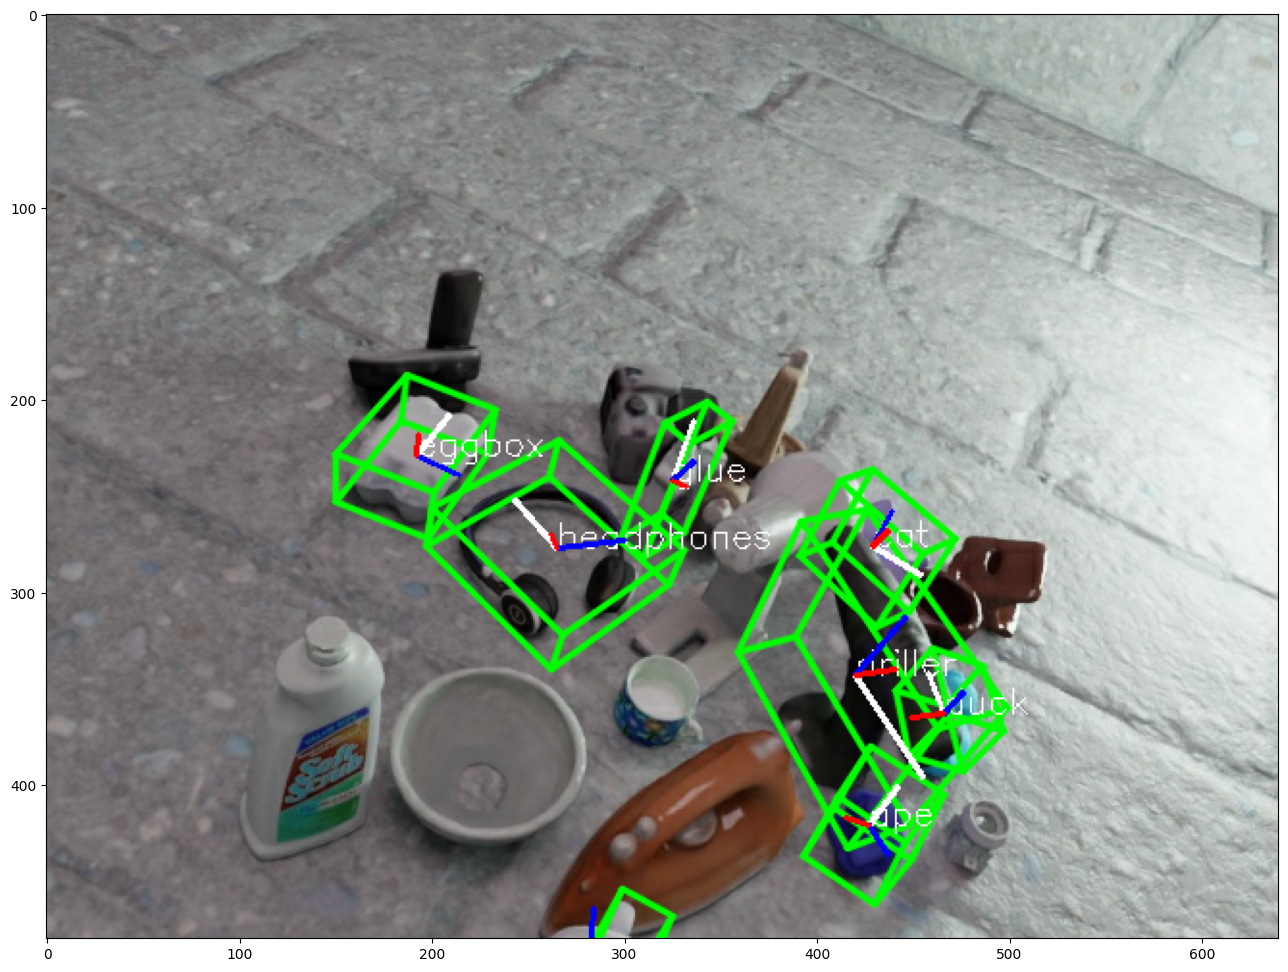

In [17]:
import matplotlib.pyplot as plt
import cv2

# fontScale
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.6
#colors
colors = {'blue': (0, 0, 255), 'red': (255, 0, 0), 'white': (255, 255, 255)}
# Line thickness of 2 px
thickness = 2

#img_test = cv2.imread(img_gt_key.replace('json', 'jpg'))

for n, obj in enumerate(img_gt_labels): 
    
    text = obj_dict[obj]
    
    coords = img_gt_labels[obj]['centroid']
    coords = [int(i) for i in coords]
    
    # get color if good or bad label
    color = img_gt_labels[obj]['color']
    color = colors[color]
        
    img_test2 = cv2.putText(img, # use image from output above to get bounding box
                           text, 
                           coords, #[50, 100], 
                           fontFace = font, 
                           fontScale = fontScale, 
                           color = color, 
                           thickness = 1)
    
    #if obj == 'obj_000016': # headphones
    keypoints = img_gt_keypoints[obj]['keypoints']

    top_coords, right_coords, front_coords = draw_axes(keypoints)

    img_test2 = cv2.line(img, coords, top_coords, 
                     colors['white'], thickness)

    img_test2 = cv2.line(img, coords, right_coords, 
                             colors['red'], thickness)

    img_test2 = cv2.line(img, coords, front_coords, 
                             colors['blue'], thickness)
            
        
    
img2 = img_test2[:,:,::-1]
plt.figure(figsize=(10*2,6*2))
plt.imshow(img2)

cv2.destroyAllWindows() 
